# Environment setup

In [1]:
!curl ipinfo.io

{
  "ip": "34.90.244.241",
  "hostname": "241.244.90.34.bc.googleusercontent.com",
  "city": "Groningen",
  "region": "Groningen",
  "country": "NL",
  "loc": "53.2192,6.5667",
  "org": "AS15169 Google LLC",
  "postal": "9711",
  "timezone": "Europe/Amsterdam",
  "readme": "https://ipinfo.io/missingauth"
}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install simpletransformers &> /dev/null
! pip install odfpy &> /dev/null

# Latex for output
! apt install texlive-latex-recommended -qq &> /dev/null
! apt install texlive-latex-extra -qq &> /dev/null
! apt install dvipng -qq &> /dev/null
! apt install cm-super -qq &> /dev/null

# Load repository

!git clone https://github.com/dafrie/fin-disclosures-nlp.git &> /dev/null
%cd /content/fin-disclosures-nlp

/content/fin-disclosures-nlp


In [ ]:
import os

from simpletransformers.classification import (
    MultiLabelClassificationModel, MultiLabelClassificationArgs
)
import numpy as np
import pandas as pd
import sklearn
import logging

from data import evaluation

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Config

## Task setup

In [ ]:
class Params:
  TASK = "multi-label" #@param ["multi-label", "binary"]
  CATEGORY_LEVEL = 'cro_sub_type' #@param ["cro", "cro_sub_type"]
  SCENARIO = "realistic" #@param [ "optimistic", "realistic", "discriminatory"]

  # Evaluation metric config. See for context: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
  AVERAGING_STRATEGY = 'macro' #@param ["micro",  "macro", "weighted"]

  RESULTS_FILE_NAME = f"{CATEGORY_LEVEL}_{TASK}_results.csv"

  # To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
  SEED_VALUE = 4200

params = Params()

## Model setup

In [ ]:
# See list here: https://huggingface.co/models
params.MODEL_TYPE  = 'roberta' #@param ["bert", "distilbert", "albert", "roberta", "xlmroberta", "xlnet"]
params.MODEL_NAME = 'roberta-large' #@param ["bert-base-uncased", "bert-large-uncased", "albert-base-v2", "albert-large-v2", "albert-xlarge-v2", "albert-xxlarge-v2", "roberta-base", "roberta-large", "distilbert-base-uncased", "distilbert-base-cased", "xlnet-base-cased", "xlnet-large-cased"]
params.model_name = params.MODEL_NAME


# Learning params
params.ENABLE_FINETUNING = True #@param {type:"boolean"}
params.SHOULD_HYPERPARAMETER_SEARCH = False #@param {type:"boolean"}

# The DataLoader needs to know our batch size for training. BERT Authors recommend 16 or 32, however this leads to an error due to not enough GPU memory
params.BATCH_SIZE = 16 #@param ["8", "16", "32"] {type:"raw"}
#parameters['max_token_size'] = 256 #@param [512,256,128] {type:"raw"}
params.EPOCHS = 4 # @param [1,2,3,4, 5, 6, 10, 20, 30, 40] {type:"raw"}
#parameters['learning_rate'] = 2e-5
#parameters['weight_decay'] = 0

## Data setup

In [ ]:
params.scenario = params.SCENARIO
params.VALIDATION_SPLIT = 0.5
params.DIR = "/content/drive/MyDrive/fin-disclosures-nlp"
params.DATA_DIR = os.path.join(params.DIR, "data", "labels")
params.MODELS_DIR = os.path.join(params.DIR, "models")
params.RESULTS_DIR = os.path.join(params.DIR, 'results')
params.RESULTS_FILE_PATH = os.path.join(params.RESULTS_DIR, params.RESULTS_FILE_NAME)

# Setup

In [ ]:
# Load/Initialize results file
results = evaluation.Results(params.RESULTS_FILE_PATH, vars(params))

## Data loading

In [ ]:
if params.CATEGORY_LEVEL == "cro":
  CATEGORY_CODES = ["PR", "TR"]
else: 
  CATEGORY_CODES = ["ACUTE", "CHRON", "POLICY", "MARKET", "REPUT"]
from sklearn.model_selection import train_test_split

train_df = pd.read_csv(os.path.join(params.DATA_DIR, f"train_explicit.csv"))
train_df = train_df.sample(frac=1, random_state=params.SEED_VALUE)

train_df["PR"] = train_df[["ACUTE", "CHRON"]].any(axis=1)
train_df["TR"] = train_df[["POLICY", "MARKET", "REPUT"]].any(axis=1)

train_text = train_df.text
train_labels = train_df[CATEGORY_CODES]

In [ ]:
valid_df = pd.read_csv(os.path.join(params.DATA_DIR, f"valid_{params.SCENARIO}.csv"))
valid_df = valid_df.sample(frac=1, random_state=params.SEED_VALUE)

test_df = pd.read_csv(os.path.join(params.DATA_DIR, f"test_{params.SCENARIO}.csv"))
test_df = test_df.sample(frac=1, random_state=params.SEED_VALUE)

valid_df["PR"] = valid_df[["ACUTE", "CHRON"]].any(axis=1)
valid_df["TR"] = valid_df[["POLICY", "MARKET", "REPUT"]].any(axis=1)

test_df["PR"] = test_df[["ACUTE", "CHRON"]].any(axis=1)
test_df["TR"] = test_df[["POLICY", "MARKET", "REPUT"]].any(axis=1)

valid_text = valid_df.text
valid_labels = valid_df[CATEGORY_CODES]

test_text = test_df.text
test_labels = test_df[CATEGORY_CODES]

In [ ]:
train_df = pd.DataFrame(data={ 'text': train_text, 'labels': train_labels.to_numpy().tolist() })
valid_df = pd.DataFrame(data={ 'text': valid_text, 'labels': valid_labels.to_numpy().tolist() })
test_df = pd.DataFrame(data={ 'text': test_text, 'labels': test_labels.to_numpy().tolist() })

## Calculate positive weights

In [ ]:
def get_pos_weights(labels):
  """Calculates weights for each class that relates to the ratio of positive to negative sample in each class"""
  pos_counts = np.sum(labels, axis=0)
  neg_counts = [len(labels) - pos_count for pos_count in pos_counts]
  pos_weights = neg_counts / pos_counts
  return pos_weights.to_list()

pos_weights = get_pos_weights(train_labels)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


# Model initialization

In [ ]:
# !rm -rf outputs

model_id = params.SCENARIO + "_" + params.MODEL_NAME + "_" + params.CATEGORY_LEVEL
print(f"Selected {params.MODEL_NAME} as transformer model for the task to classification of {params.CATEGORY_LEVEL}...")
best_model_dir = os.path.join(params.MODELS_DIR, params.TASK, model_id)
os.makedirs(best_model_dir, exist_ok=True)
print(f"Storing best model to: {best_model_dir}")

# Config: https://simpletransformers.ai/docs/usage/
model_args = MultiLabelClassificationArgs(
    num_train_epochs=params.EPOCHS, 
    best_model_dir=best_model_dir,
    manual_seed=params.SEED_VALUE,
    train_batch_size=params.BATCH_SIZE,
    # use_early_stopping=True,
    # evaluate_during_training=True,
    overwrite_output_dir=True,
    # early_stopping_metric="...".
    # early_stopping_metric_minimize
)

# Model
model = MultiLabelClassificationModel(
    params.MODEL_TYPE,
    params.MODEL_NAME,
    args=model_args,
    num_labels=len(train_labels.columns),
    pos_weight=pos_weights,
)

Selected roberta-large as transformer model for the task to classification of cro_sub_type...
Storing best model to: /content/drive/MyDrive/fin-disclosures-nlp/models/multi-label/realistic_roberta-large_cro_sub_type


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'c

# Model training

In [ ]:
model.train_model(
    train_df, 
    eval_df=valid_df,
)


INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_0_2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


(128, 0.8175954812322743)

## Model eval

In [ ]:
# Evaluate the model
valid_result, valid_model_outputs, valid_wrong_predictions = model.eval_model(
    valid_df,
    roc_auc=lambda truth, preds: sklearn.metrics.roc_auc_score(truth, preds, average=params.AVERAGING_STRATEGY),
    pr_auc=lambda truth, preds: sklearn.metrics.average_precision_score(truth, preds, average=params.AVERAGING_STRATEGY)
)
valid_result

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/39079 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_0_2


Running Evaluation:   0%|          | 0/4885 [00:00<?, ?it/s]

{'LRAP': 0.9996247984851198,
 'eval_loss': 0.047047721562924256,
 'pr_auc': 0.3338309176240962,
 'roc_auc': 0.9790825009658823}

## Optimal threshold values

/content/fin-disclosures-nlp/data/evaluation.py:127: RuntimeWarning: invalid value encountered in true_divide
  ) / (precision[idx] + recall[idx])
/content/fin-disclosures-nlp/data/evaluation.py:130: RuntimeWarning: invalid value encountered in true_divide
  1 + beta*beta) * ((precision[idx] * recall[idx]) / ((beta*beta*precision[idx]) + recall[idx]))
/content/fin-disclosures-nlp/data/evaluation.py:127: RuntimeWarning: invalid value encountered in true_divide
  ) / (precision[idx] + recall[idx])
/content/fin-disclosures-nlp/data/evaluation.py:130: RuntimeWarning: invalid value encountered in true_divide
  1 + beta*beta) * ((precision[idx] * recall[idx]) / ((beta*beta*precision[idx]) + recall[idx]))
/content/fin-disclosures-nlp/data/evaluation.py:127: RuntimeWarning: invalid value encountered in true_divide
  ) / (precision[idx] + recall[idx])
/content/fin-disclosures-nlp/data/evaluation.py:130: RuntimeWarning: invalid value encountered in true_divide
  1 + beta*beta) * ((precision[idx]

,ROC AuC,PR AuC
0,0.979083,0.333831


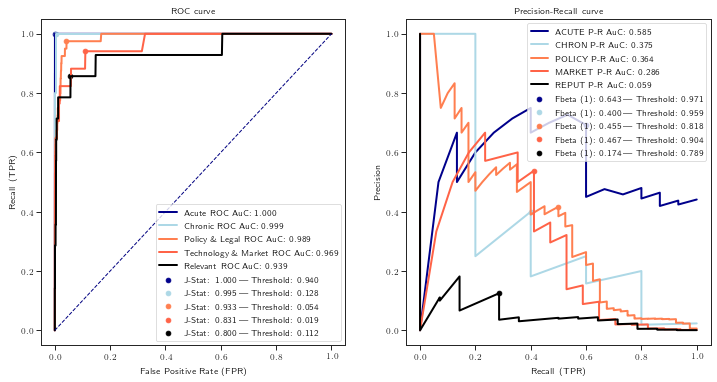

In [ ]:
valid_threshold_moving_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_valid_threshold.pdf")
valid_eval_scores, best_roc_threshold, best_pr_threshold = evaluation.threshold_moving_report(valid_labels, valid_model_outputs, export_path=valid_threshold_moving_report, beta=1)

#results.log_experiment(train_eval_scores, prefix="valid")
results.log_experiment({"epochs": params.EPOCHS})
results.log_experiment({ "best_pr_threshold": best_pr_threshold.values(), "best_roc_threshold": best_roc_threshold.values()}, prefix="valid")
valid_eval_scores

Using threshold values dict_values([0.970703125, 0.958984375, 0.818359375, 0.90380859375, 0.7890625])
              precision    recall  f1-score   support

       ACUTE       0.73      0.53      0.62        15
       CHRON       0.25      0.20      0.22         5
      POLICY       0.40      0.47      0.44        40
      MARKET       0.50      0.35      0.41        17
       REPUT       0.07      0.14      0.09        14

   micro avg       0.35      0.40      0.37        91
   macro avg       0.39      0.34      0.36        91
weighted avg       0.41      0.40      0.40        91
 samples avg       0.00      0.00      0.00        91



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


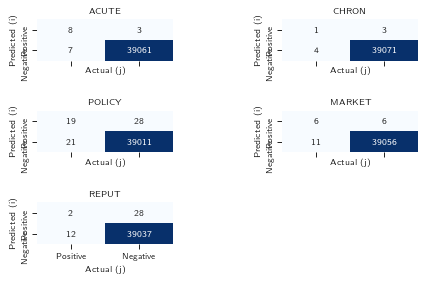

,ROC AuC,PR AuC,F1,Report,CMS
0,0.979083,0.333831,0.355818,"{""ACUTE"": {""precision"": 0.7272727272727273, ""r...","[[[8, 3], [7, 39061]], [[1, 3], [4, 39071]], [..."


In [ ]:
valid_evaluation_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_valid_evaluation.pdf")
valid_eval_scores = evaluation.test_evaluation_report(valid_labels, valid_model_outputs, best_pr_threshold.values(), export_path=valid_evaluation_report)
results.log_experiment(valid_eval_scores, prefix="valid")
valid_eval_scores

# Model test

In [ ]:
should_test = True

if should_test:
  test_result, test_model_outputs, test_wrong_predictions = model.eval_model(
      test_df,
      # fbeta=lambda truth, preds: sklearn.metrics.fbeta_score(truth, (preds > best_pr_threshold.values()), beta=3),
      roc_auc=lambda truth, preds: sklearn.metrics.roc_auc_score(truth, preds, average=params.AVERAGING_STRATEGY),
      pr_auc=lambda truth, preds: sklearn.metrics.average_precision_score(truth, preds, average=params.AVERAGING_STRATEGY)
  )
  test_result

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/40975 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_0_2


Running Evaluation:   0%|          | 0/5122 [00:00<?, ?it/s]

Using threshold values dict_values([0.970703125, 0.958984375, 0.818359375, 0.90380859375, 0.7890625])
              precision    recall  f1-score   support

       ACUTE       0.85      0.39      0.54        28
       CHRON       0.83      0.26      0.40        19
      POLICY       0.29      0.38      0.33        60
      MARKET       0.40      0.48      0.43        21
       REPUT       0.09      0.29      0.14        14

   micro avg       0.32      0.37      0.34       142
   macro avg       0.49      0.36      0.37       142
weighted avg       0.47      0.37      0.38       142
 samples avg       0.00      0.00      0.00       142



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


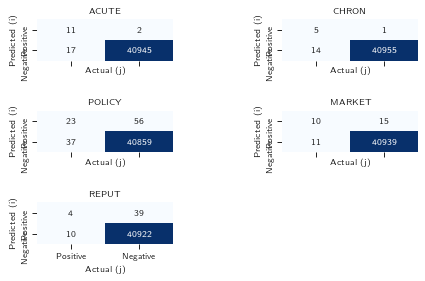

In [ ]:
if should_test:
  test_evaluation_report = os.path.join(params.RESULTS_DIR, "figures", f"{params.CATEGORY_LEVEL}_{params.TASK}_{params.SCENARIO}_{params.MODEL_NAME}_test_evaluation.pdf")
  test_eval_scores = evaluation.test_evaluation_report(test_labels, test_model_outputs, best_pr_threshold.values(), export_path=test_evaluation_report)
  results.log_experiment(test_eval_scores, prefix="test")
  test_eval_scores


## Copy model (todo: Should copy best model! But need to evaluate properly)

In [ ]:
! cp outputs/checkpoint-128-epoch-4/* $best_model_dir